In [1]:
import torch
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
from torch.utils.data import DataLoader
import random

In [2]:
#Architecture parameters and distributions of stimuli
N = 20
K = 10
p_x = torch.distributions.exponential.Exponential(0.5)

#Training parameters
N_EPOCHS = 5000
N_SAMPLES = 500
lr = 1e-2
BATCH_SIZE = 500
#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]  #creates a 1D tensor of size 1000 whose values are evenly spaced from x_min and x_max



In [3]:
#Initialization of encoder and decoder 
enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted)
#inv_sigma2 = torch.exp(-2*enc.log_sigmas).transpose(0,1)
#phi0 = torch.cat((enc.cs.transpose(0,1)*inv_sigma2,-0.5*inv_sigma2),dim=1)  #(-mu/(sigma)^2 , -1/2*(sigma^2))
dec_perc = MLPDecoder(N,200)


Text(0, 0.5, 'Encoding')

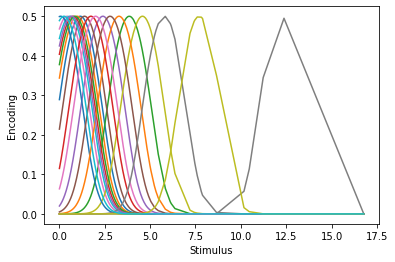

In [12]:
#Initialized encoder before training
plt.plot(x_sorted,torch.sigmoid(enc(x_sorted)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

In [4]:
#create the matrix of the total possible vectors of r (possible patterns) for N=10 neurons
N = 20
r1 = np.asarray(list(itertools.product([0, 1], repeat=N)))
r1.shape
r = torch.tensor(r1).transpose(0,1)
r.shape

torch.Size([20, 1048576])

GRADIENT DESCENT ON THE WHOLE SET OF PARAMETERS ( encoder, h, J)     TO DO

In [5]:
#Definition of the rate function for the Ising prior

class rate_ISING(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        h0 = torch.zeros((1,N)).type(torch.float)
        J0 = torch.eye(N).type(torch.float)
        self.h = torch.nn.Parameter(h0)
        self.J = torch.nn.Parameter(J0)
    def forward(self,x):
        eta = enc(x) 
        r1 = np.asarray(list(itertools.product([0, 1], repeat=N)))
        r = torch.tensor(r1).transpose(0,1).type(torch.float)
        p_r_x = torch.exp(eta@r - (torch.log( 1 + torch.exp(eta))).sum(dim=1)[:,None])
        log_ratio = ((eta-self.h)@r - (r*(self.J@r)).sum(dim=0, keepdim=True) - (torch.log(1+torch.exp(eta))).sum(dim=1)[:,None])
        logz = torch.log((torch.exp((self.h@r) + (r*(self.J@r)).sum(dim=0, keepdim=True))).sum(dim=1))
        
        return ((p_r_x)*(log_ratio)).sum(dim=1).mean() + logz


I want to find the best parameters h and J that minimize the rate considering a fixed encoder whose parameters are kept equal to the initialized ones

In [18]:
lossVec = []
rateVec = []
distVec = []
rate_i = rate_ISING()
J0 = torch.eye(N).type(torch.float)
h0 = torch.zeros((1,N)).type(torch.float)
params = list(dec_perc.parameters()) + list(rate_i.parameters())
optimizer = torch.optim.Adam(params,lr)
for epoch in range(N_EPOCHS):
    for x_ in x_data:
        loss = distortion_gaussian(x_,enc,dec_perc) + rate_i(x_)
        #print(loss)
        rate = rate_i(x_)
        dist = distortion_gaussian(x_,enc,dec_perc)
        lossVec.append(loss.item())
        rateVec.append(rate.item())
        distVec.append(dist.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

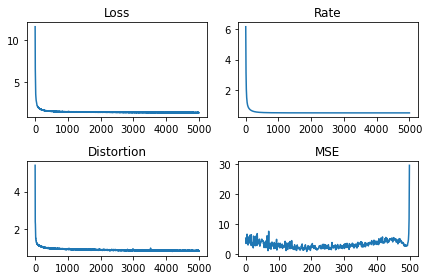

In [ ]:
r = enc.sample(x_sorted,100)
x_dec = dec_perc.sample(r,100)
mseVec = ((x_dec - x_sorted[None,:])**2).mean(dim=(0,2))

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(lossVec)
axs[0, 0].set_title('Loss')
axs[0, 1].plot(rateVec)
axs[0, 1].set_title('Rate')
axs[1, 0].plot(distVec)
axs[1, 0].set_title('Distortion')
axs[1, 1].plot(mseVec)
axs[1, 1].set_title('MSE')
fig.tight_layout()

In [83]:
rate_i.h

Parameter containing:
tensor([[-0.5876, -0.6010, -0.5793, -0.5700, -0.5721, -0.7464, -1.1628, -0.5853,
         -0.5722, -0.6261]], requires_grad=True)

Text(0.5, 1.0, 'Optimal J')

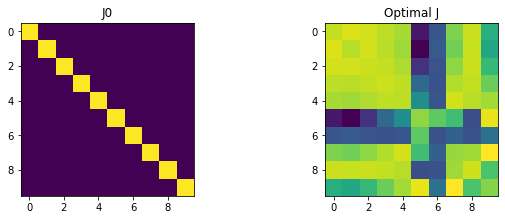

In [42]:
a = (rate_i.J).detach()
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(J0)
plt.title("J0")

fig.add_subplot(rows, columns, 2)
plt.imshow(a)
plt.title("Optimal J")

Given the optimal h and J, I want to see how the rate changes when varying the sigmas of the encoding process tuning curves.


In [97]:
opt_h = rate_i.h
opt_J = rate_i.J

In [6]:
def initialize_bernoulli_params(N,x_min,x_max,xs,w):
    #Initialize parameters arranging centers equally spaced in the range x_min x_max,
    # and the width as 5 times the spacing between centers
    #initialize cs using kmeans:
    kmeans = cluster.KMeans(n_clusters=N, init='random',
                        n_init=10, max_iter=10, random_state=2)
    C = kmeans.fit_predict(xs)
    centers = kmeans.cluster_centers_
    cs = torch.nn.Parameter(torch.Tensor(centers).transpose(0,1))
    #cs = torch.nn.Parameter(torch.arange(x_min,x_max,(x_max-x_min)/N)[None,0:N])
    log_sigmas = torch.nn.Parameter(torch.log(torch.ones(N)*(x_max-x_min)/w)[None,:])
    As = torch.nn.Parameter(torch.ones(N)[None,:])
    return cs,log_sigmas,As

def rate_ising3(x,encoder,h,J):
    eta = encoder(x)
    r1 = np.asarray(list(itertools.product([0, 1], repeat=N)))
    r = torch.tensor(r1).transpose(0,1).type(torch.float)
    p_r_x = torch.exp(eta@r - (torch.log( 1 + torch.exp(eta))).sum(dim=1)[:,None])
    log_ratio = ((eta-h0)@r - (r*(J0@r)).sum(dim=0, keepdim=True) - (torch.log(1+torch.exp(eta))).sum(dim=1)[:,None])
    logz = torch.log((torch.exp((h0@r) + (r*(J0@r)).sum(dim=0, keepdim=True))).sum(dim=1))

    return ((p_r_x)*(log_ratio)).sum(dim=1).mean() + logz

class BernoulliEncoder(torch.nn.Module):
    # Encoder returning for N neurons their unnormalized probabilities of being active (i.e. logits),as 
    # a quadratic function of x
    def __init__(self,N,x_min,x_max,xs,w):
        super().__init__()
        self.cs, self.log_sigmas,self.As  = initialize_bernoulli_params(N,x_min,x_max,xs,w)
    def forward(self,x):
        # x has shape [bsize_dim,x_dim], c,log_sigma,A has shape [x_dim, N]
        inv_sigmas = 0.5*torch.exp(-2*self.log_sigmas)
        etas = -(x**2)@inv_sigmas
        etas2 = + 2*x@((self.cs*inv_sigmas))
        etas3 = - (self.cs**2)*inv_sigmas + torch.log(self.As)
        return etas + etas2 + etas3

    def sample(self,x,nsamples):
        p_r_x = torch.distributions.bernoulli.Bernoulli(logits = self.forward(x))
        r = p_r_x.sample((nsamples,)).transpose(0,1)
        return r

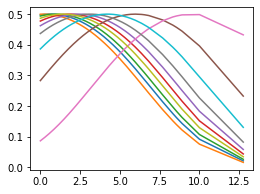

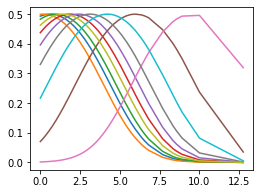

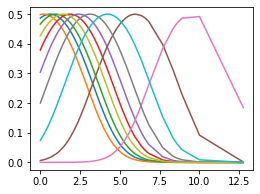

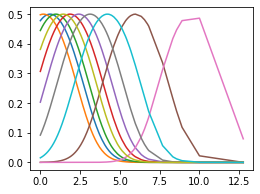

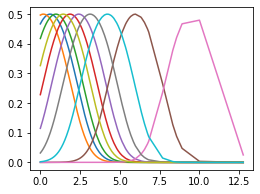

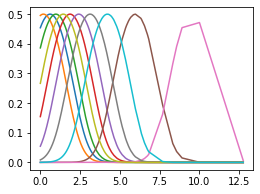

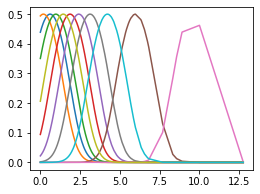

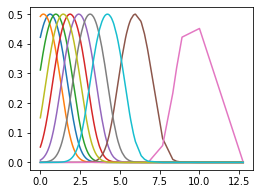

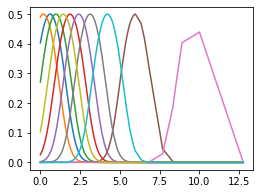

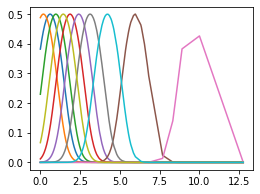

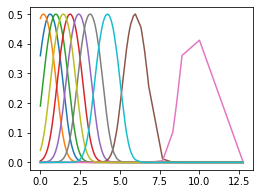

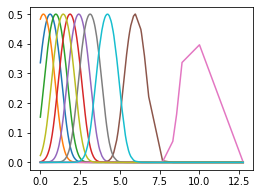

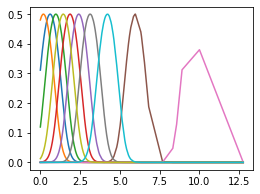

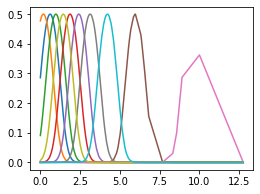

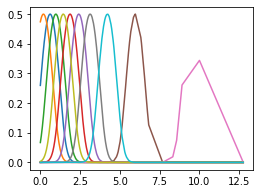

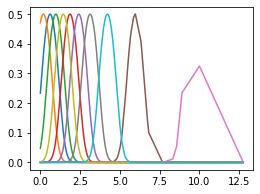

In [88]:
#fig = plt.figure(figsize=(10, 7))
for w in range(3,35,2):
    fig = plt.figure(figsize=(4, 3))
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted,w)
    fig.add_subplot()
    plt.plot(x_sorted,torch.sigmoid(enc(x_sorted)).detach())

In [89]:
rateVec = []
for w in range(3,30,2):
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted,w)
    rate = rate_ising3(x_sorted, enc, opt_h, opt_J)
    rateVec.append(rate.item())


Text(0, 0.5, 'Rate')

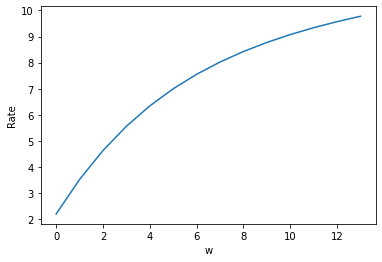

In [90]:
plt.plot(rateVec)
plt.xlabel("w")
plt.ylabel("Rate")

I want to check how J varies when the sigmas are varied. The encoder is fixed, I'm performing gradient descent only on h and J.

In [110]:
J0 = torch.eye(N).type(torch.float)
h0 = torch.zeros((1,N)).type(torch.float)
Js = []
for w in range(1,40,5):
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted,w)
    rate_i = rate_ISING()
    params = list(dec_perc.parameters()) + list(rate_i.parameters())
    optimizer = torch.optim.Adam(params,lr)
    for epoch in range(N_EPOCHS):
       for x_ in x_data:
           loss = distortion_gaussian(x_,enc,dec_perc) + rate_i(x_)
           optimizer.zero_grad()
           loss.backward()
           optimizer.step()
    J_item = rate_i.J.detach()
    #plt.imshow(J_item)
    Js.append(J_item)
    

    


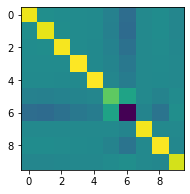

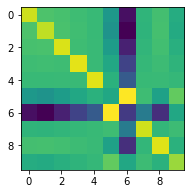

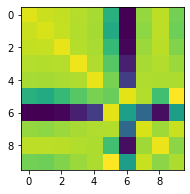

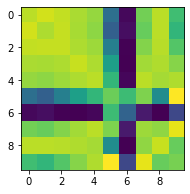

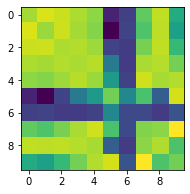

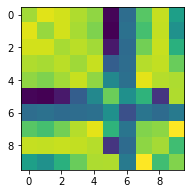

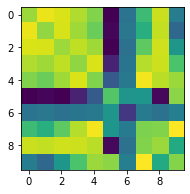

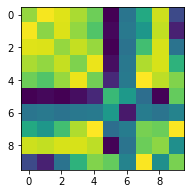

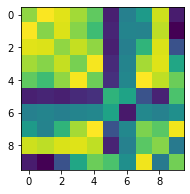

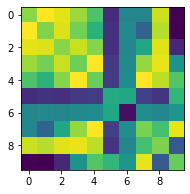

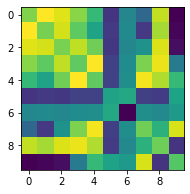

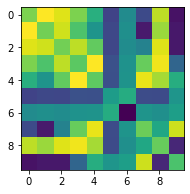

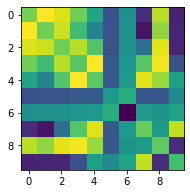

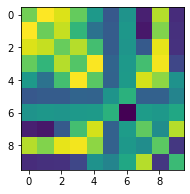

In [115]:
for item in Js:
    fig = plt.figure(figsize=(4, 3))
    fig.add_subplot()
    plt.imshow(item)
    
    